## One station MODELS
LSTM_tensorflow_tutorial [link](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math
from scipy import stats
import json

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
files_ids = {'guadalupe':'guadalupe_validation.csv',
         'banos':'banos_validation.csv',
         'aeropuerto': 'aeropuerto_validation.csv',
         'quisapincha':'quisapincha_validation.csv',
         'chiquiurco':'chiquiurco_validation.csv',
         'AJSucre':'AJSucre_validation.csv',
         'JAlvarez':'JAlvarez_validation.csv',
         'pfc-hgpt':'pfc-hgpt_validation.csv',
         'calamaca':'calamaca_validation.csv',
         'mulaCorral':'mulaCorral_validation.csv',
         'pampasSalasaca':'pampasSalasaca_validation.csv',
         'tasinteo':'tasinteo_validation.csv',
         'pisayambo':'pisayambo_validation.csv'
         }

In [3]:
### Set fixed variables
input_path = 'data/PROCESSED/STATIONS_CLEAN'
path = 'data/PROCESSED/MODEL_OUTPUTS'
station = 'banos'

In [4]:
## sampling frequency
sample_freq = 60 #(time in minutes)
steps=int(sample_freq/5)
time_steps = int(60/sample_freq)

In [5]:
df = pd.read_csv(f'{input_path}/{station}_validation.csv')

In [6]:
### Subsample to get data for every hour (starting from index 0, get 12 steps)
df = df[0::steps]

In [7]:
date_time = pd.to_datetime(df.pop('Date_Time'), format='%Y-%m-%d %H:%M:%S')

(19.0, 0.0)

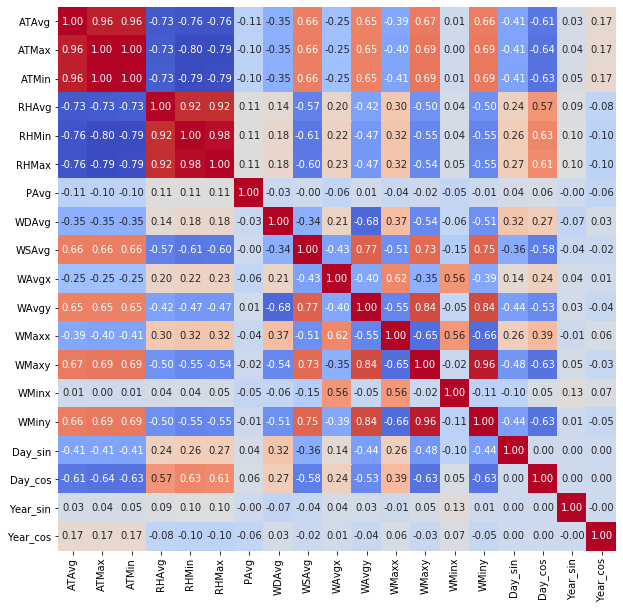

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(df.corr(), annot=True, fmt='.2f', 
            cmap='coolwarm', cbar=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
    #fig.savefig(f'{path}/{aggregate_files[i][0]}_corrmatrix.png',dpi = 75)

In [9]:
(df.corr().unstack()['ATAvg']>0.5) | (df.corr().unstack()['ATAvg']<-0.5)

ATAvg        True
ATMax        True
ATMin        True
RHAvg        True
RHMin        True
RHMax        True
PAvg        False
WDAvg       False
WSAvg        True
WAvgx       False
WAvgy        True
WMaxx       False
WMaxy        True
WMinx       False
WMiny        True
Day_sin     False
Day_cos      True
Year_sin    False
Year_cos    False
dtype: bool

In [10]:
np.where((df.corr().unstack()['ATAvg']>0.5) | (df.corr().unstack()['ATAvg']<-0.5)==True)

(array([ 0,  1,  2,  3,  4,  5,  8, 10, 12, 14, 16]),)

In [11]:
### Remove PAvg and WMaxx, WMiny, WDAvg and WSAvg
df = df[['ATAvg',
         'RHAvg',
         'WSAvg',
         'WAvgx',
         'WAvgy',
         'Day_sin', 
         'Day_cos']]

In [12]:
### Split data into 70%, 20%, 10% split for the training, validation, and test sets
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [13]:
# ### Standarized the data  
# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std
# scaler_type = 'mean'

In [14]:
subset= 'train'
min_date= date_time[train_df.index.min()].date()
max_date = date_time[train_df.index.max()].date()
print(f'{subset} data range: {min_date} to {max_date}')

train data range: 2013-01-11 to 2017-12-03


In [15]:
subset= 'val'
min_date= date_time[val_df.index.min()].date()
max_date = date_time[val_df.index.max()].date()
print(f'{subset} data range: {min_date} to {max_date}')

val data range: 2017-12-03 to 2019-04-28


In [16]:
subset= 'test'
min_date= date_time[test_df.index.min()].date()
max_date = date_time[test_df.index.max()].date()
print(f'{subset} data range: {min_date} to {max_date}')

test data range: 2019-04-28 to 2020-01-08


In [17]:
### make a copy of unscaled data
train_df_raw = train_df.copy()
test_df_raw = test_df.copy()
val_df_raw = val_df.copy()

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df[train_df.columns] = scaler.fit_transform(train_df[train_df.columns])
test_df[test_df.columns] = scaler.fit_transform(test_df[test_df.columns])
val_df[val_df.columns] = scaler.fit_transform(val_df[val_df.columns])
scaler_type='minmax'

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [19]:
# from sklearn.preprocessing import StandardScaler

# # copy of datasets
# num_cols = df.columns

# # apply standardization on numerical features
# for i in num_cols:
    
#     # fit on training data column
#     scale = StandardScaler().fit(df_train[[i]])
    
#     # transform the training data column
#     df_train[i] = scale.transform(df_train[[i]])
#     df_test[i] = scale.transform(df_test[[i]])
#     df_val[i] = scale.transform(df_val[[i]])
# scaler_type='stand'  

In [20]:
%run model_utils.ipynb

In [21]:
num_features = df.shape[1]
vars_to_analize = ['ATAvg','RHAvg']

In [22]:
input_width = 48*time_steps
OUT_STEPS =24*time_steps
#performance = multi_models(station, path, num_features,input_width, OUT_STEPS)

In [23]:
MAX_EPOCHS = 20
batch_size = 64

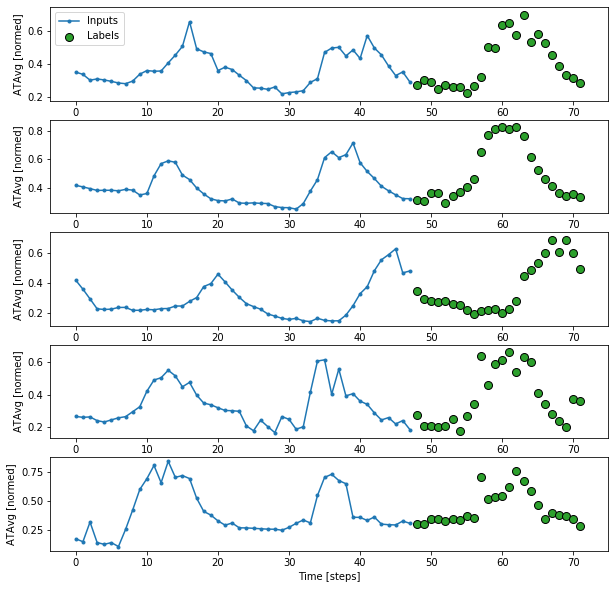

In [24]:
multi_val_performance = {}
multi_performance = {}
r2 ={}

## window
window = WindowGenerator(
input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS)
window.plot(plot_col=list(window.column_indices.keys())[0])

## 1 LSTM layer

191/191 [==============================] - 2s 12ms/step - loss: 0.0095 - mean_absolute_error: 0.0643


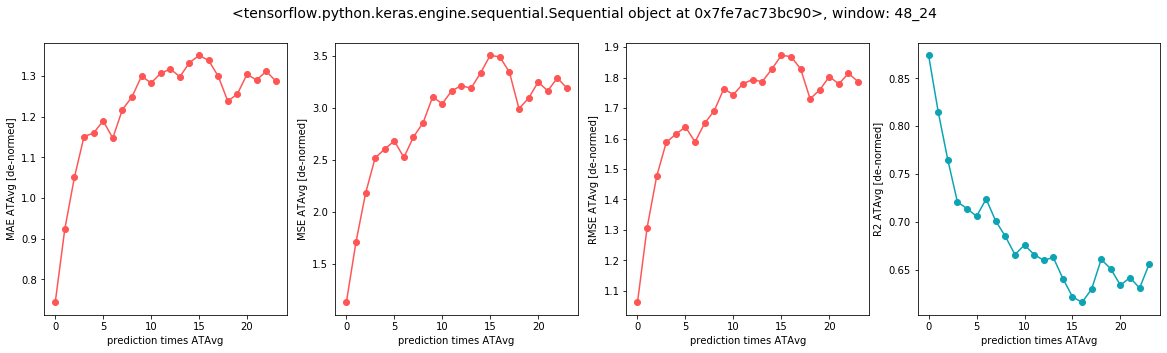

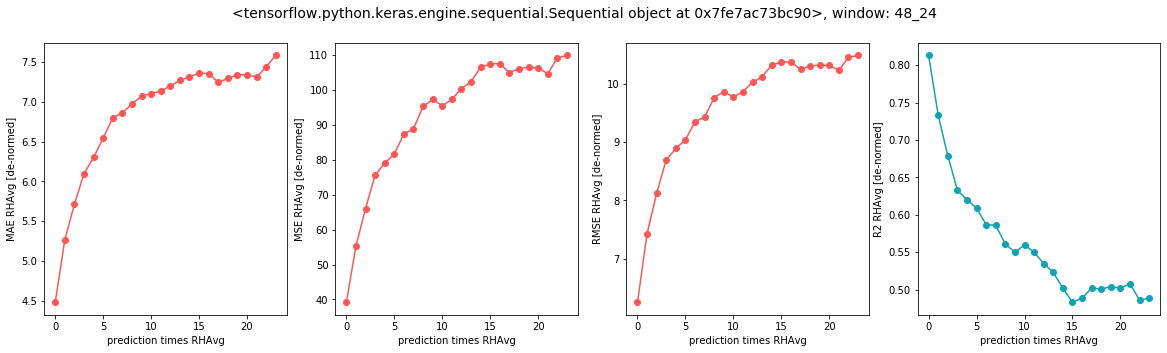

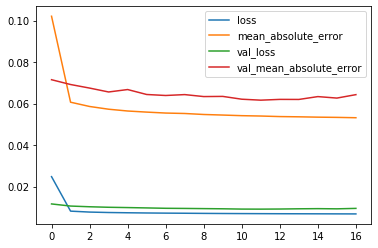

In [25]:
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
# Shape [batch, time, features] => [batch, lstm_units]
# Adding more `lstm_units` just overfits more quickly.
tf.keras.layers.LSTM(batch_size, return_sequences=False),
# Shape => [batch, out_steps*features]
tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
# Shape => [batch, out_steps, features]
tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'minmax',plot=True)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')

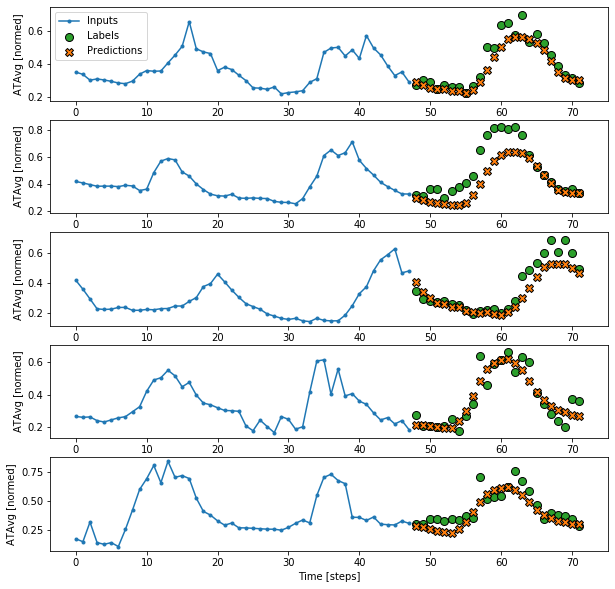

In [26]:
window.plot(multi_lstm_model)

### 2 LSTM layers

191/191 [==============================] - 4s 19ms/step - loss: 0.0096 - mean_absolute_error: 0.0639


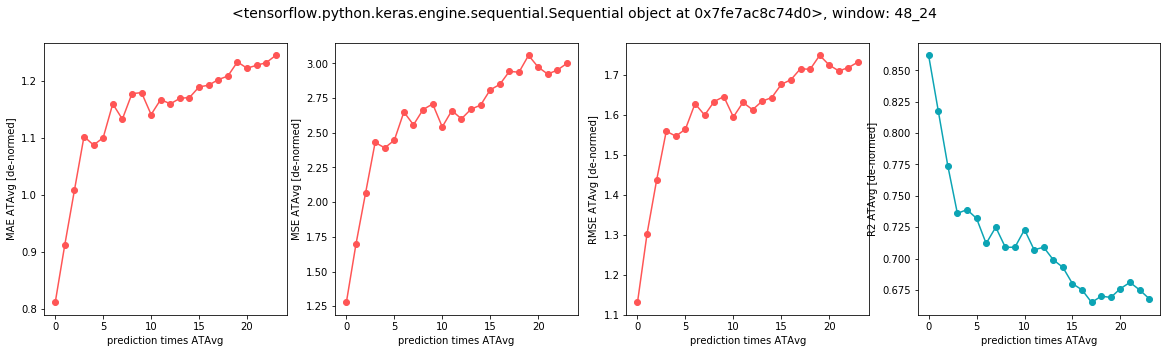

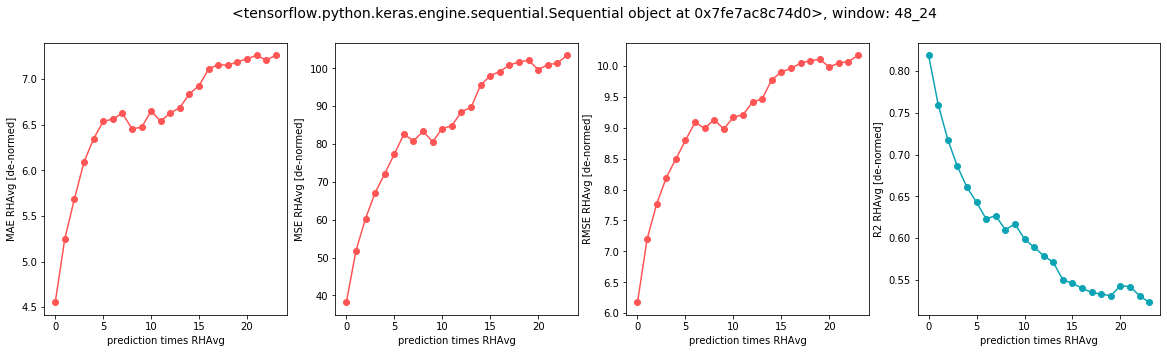

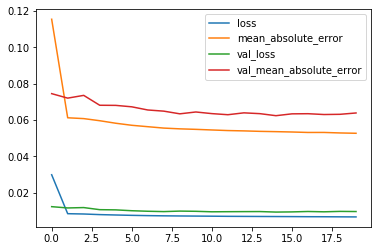

In [27]:
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.keras.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'minmax',plot=True)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm2-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm2-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')

### 3 LSTM layers

191/191 [==============================] - 7s 33ms/step - loss: 0.0097 - mean_absolute_error: 0.0644: 1s - loss: 0.0097 - mean_abs


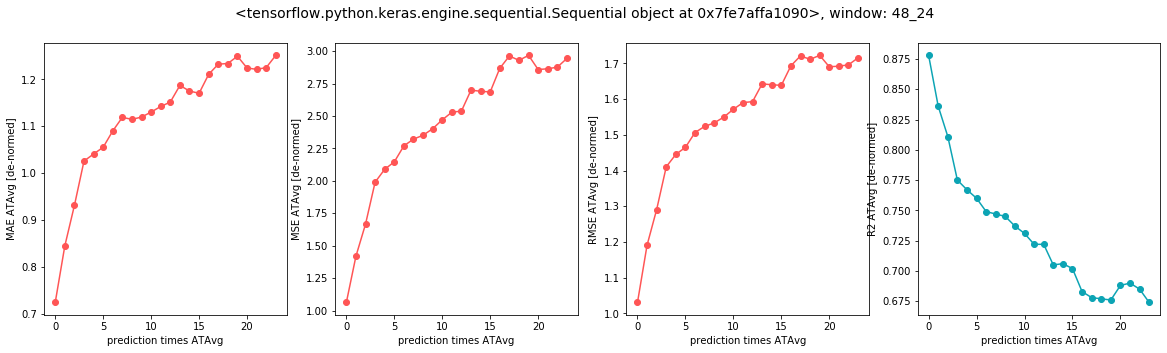

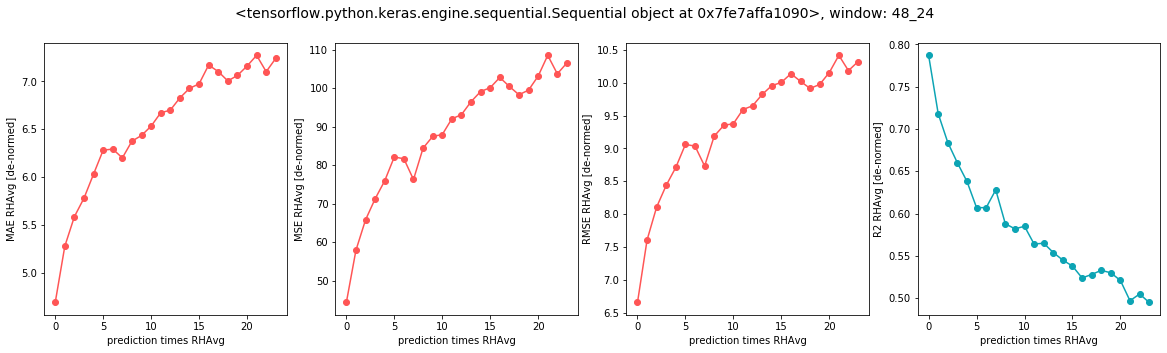

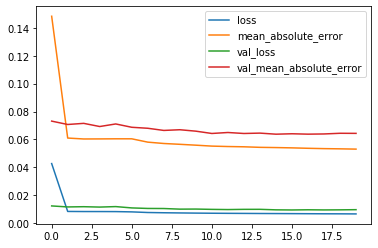

In [28]:
### RNN
print(f'RNN')
multi_val_performance = {}
multi_performance = {}
r2 ={}

multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history= compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'minmax',plot=True)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm3-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm3-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')

### 4 LSTM layers

191/191 [==============================] - 7s 34ms/step - loss: 0.0100 - mean_absolute_error: 0.0655


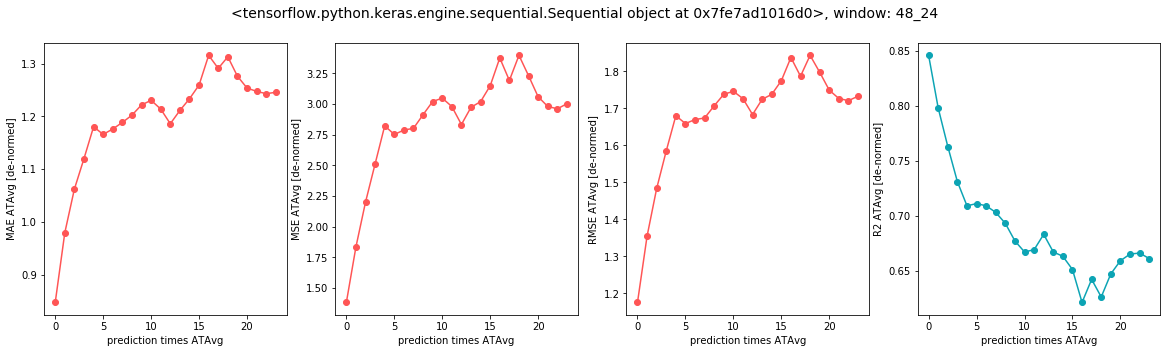

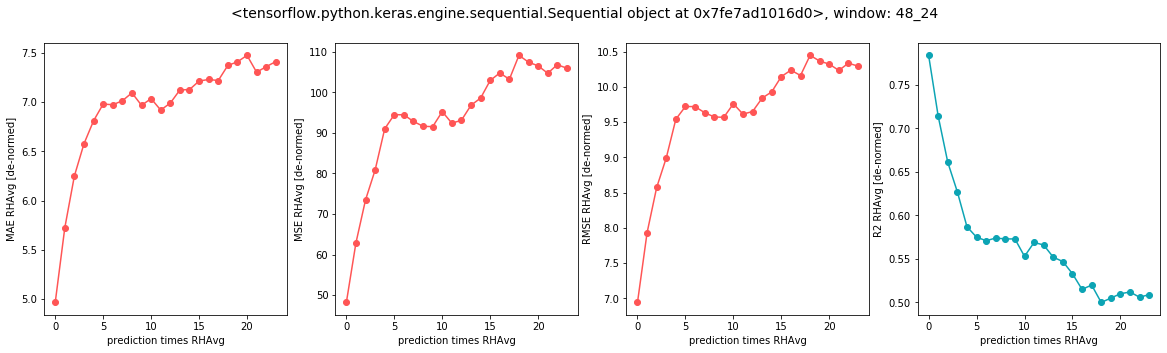

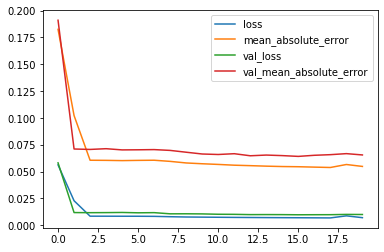

In [29]:
### RNN
print(f'RNN')
multi_val_performance = {}
multi_performance = {}
r2 ={}

multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history= compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'minmax',plot=True)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm4-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm4-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')